In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# 1. Convolution function: It accepts as input an image, a filter kernel, stride, padding and the non-linear function. The function must correlate (convolve) the input image (after padding if specified) with the kernel (at the specified stride size) and generate an output activation after applying the specified non-linearity. Verify with the standard options for the non-linear activation functions - sigmoid, tanh, ReLU, Parametric ReLU (PReLU). Display the input image, the filter kernel and the output activation map. Ensure that your function can accept multi-channel input and a corresponding kernel volume.

def apply_padding(image, padding):
    if padding == 0:
        return image
    return np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant', constant_values=0)

def convolve(image, kernel, stride, padding, activation, activation_params=None):
    # Get the dimensions of the image and the kernel
    image_height, image_width, image_channels = image.shape
    kernel_height, kernel_width, kernel_channels = kernel.shape

    # Assert that the number of channels in the image and the kernel are the same
    if image_channels != kernel_channels:
        raise ValueError("The number of channels in the image and the kernel must be the same.")
    
    # Apply padding to the image
    image = apply_padding(image, padding)
    image_height, image_width, _ = image.shape

    # Compute the dimensions of the output
    output_height = (image_height - kernel_height) // stride + 1
    output_width = (image_width - kernel_width) // stride + 1

    output = np.zeros((output_height, output_width))
    
    # Apply the convolution operation
    for y in range(0, output_height):
        for x in range(0, output_width):
            region = image[y*stride:y*stride+kernel_height, x*stride:x*stride+kernel_width]
            output[y, x] = np.sum(region * kernel)

    # Apply the activation function
    if activation == 'sigmoid':
        output = 1 / (1 + np.exp(-output))
    elif activation == 'tanh':
        output = np.tanh(output)
    elif activation == 'relu':
        output = np.maximum(0, output)
    elif activation == 'prelu':
        if activation_params is None:
            raise ValueError("Activation parameters must be provided for the PReLU activation function.")
        alpha = activation_params
        output = np.maximum(alpha * output, output)
    else:
        raise ValueError("Unknown activation function: {}".format(activation))
    
    return output

In [34]:
# 2. Pooling function: It accepts as input the activation map output from the convolution function, a pooling function, and stride. The function must output the appropriately pooled activation map. Display the input activation map and the pooled output. Assume the pooling window to be square and pass its size as input to the function.

def pool(activation_map, pool_size, stride, pooling_function):
    # Get the dimensions of the activation map
    height, width = activation_map.shape

    # Compute the dimensions of the output
    output_height = (height - pool_size) // stride + 1
    output_width = (width - pool_size) // stride + 1

    output = np.zeros((output_height, output_width))

    # Apply the pooling operation
    for y in range(0, output_height):
        for x in range(0, output_width):
            region = activation_map[y*stride:y*stride+pool_size, x*stride:x*stride+pool_size]
            if pooling_function == 'max':
                output[y, x] = np.max(region)
            elif pooling_function == 'average':
                output[y, x] = np.mean(region)
            else:
                raise ValueError("Unknown pooling function: {}".format(pooling_function))
            
    return output

In [27]:
# 3. Convolution layer function: It accepts as input a volume (image or activation maps), filter kernels, stride, padding and the non-linear function. The function must convolve the input volume (after padding if specified) with each of the kernels (at the specified stride size) and generates an output activation volume after applying the specified non-linearity. Display the input image or activation maps, the filter kernels and the output activation maps. Verify that the output of this function does indeed have the expected size (W × H × C) 

def conv_layer(volume, kernels, stride, padding, activation, activation_params=None):

    # Display the input volume
    plt.figure(figsize=(5, 5))
    plt.imshow(volume)
    plt.title("Input Volume")
    plt.axis('off')
    plt.show()

    # Display the kernels as subplots
    plt.figure(figsize=(5, 5))
    for i in range(len(kernels)):
        plt.subplot(1, len(kernels), i + 1)
        plt.imshow(kernels[i])
        plt.title("Kernel {}".format(i + 1))
        plt.axis('off')

    num_kernels = len(kernels)

    # Get the dimensions of the volume
    image_height, image_width, image_channels = volume.shape

    # Get the dimensions of the kernel
    kernel_height, kernel_width, kernel_channels = kernels[0].shape

    # Get the output dimensions
    output_height = (image_height + 2 * padding - kernel_height) // stride + 1
    output_width = (image_width + 2 * padding - kernel_width) // stride + 1

    output = np.zeros((output_height, output_width, num_kernels))

    # Apply the convolution operation
    for i in range(num_kernels):
        output[:, :, i] = convolve(volume, kernels[i], stride, padding, activation, activation_params)
    
    # Display the output volume
    plt.figure(figsize=(10, 10))
    plt.imshow(output)
    plt.title("Output Volume")
    plt.axis('off')
    plt.show()

    return output

In [28]:
# 4. Pooling layer function: It accepts as input the activation map volume, the pooling function, stride, and generates a pooled output volume. Display the input and output volumes.

def pool_layer(volume, pool_size, stride, pooling_function):

    # Get the dimensions of the volume
    image_height, image_width, image_channels = volume.shape

    # Get the output dimensions
    output_height = (image_height - pool_size) // stride + 1
    output_width = (image_width - pool_size) // stride + 1

    output = np.zeros((output_height, output_width, image_channels))

    # Apply the pooling operation
    for c in range(image_channels):
        output[:, :, c] = pool(volume[:, :, c], pool_size, stride, pooling_function)

    return output

In [29]:
# 5. Flattening (unraveling) function: It accepts as input the activation map volume output by the pooling layer and generates a vector of a specified size. It is important to note that this function has a weight matrix associated with it whose size is chosen such that the input and desired output sizes are matched. 

def flatten(volume):
    return volume.flatten()

In [30]:
# 6. Multilayer Perceptron (MLP) function (Fully Connected): It accepts as input a vector, the number of hidden layers, the size of each hidden layer, the non-linear function, and the size of the output layer. This function should generate an output vector of the specified size. Generate the output with and without the softmax function applied to the output layer.

def apply_nonlinearity(output, activation):
    if activation == 'sigmoid':
        return 1 / (1 + np.exp(-output))
    elif activation == 'tanh':
        return np.tanh(output)
    elif activation == 'relu':
        return np.maximum(0, output)
    elif activation == 'prelu':
        alpha = 0.1
        return np.maximum(0, output) + alpha * np.minimum(0, output)
    elif activation == 'softmax':
        return np.exp(output) / np.sum(np.exp(output))
    else:
        raise ValueError("Unknown activation function: {}".format(activation))

def mlp(input_vector, hidden_layers, hidden_layer_size, activation, output_size, apply_softmax=False):
    # Initialize the weights and biases
    weights = []
    biases = []
    sizes = [input_vector.shape[0]] + [hidden_layer_size] * hidden_layers

    for i in range(hidden_layers):
        weights.append(np.random.randn(sizes[i], sizes[i + 1]))
        biases.append(np.random.randn(sizes[i + 1]))

    # Apply the forward pass
    output = input_vector
    for i in range(hidden_layers):
        output = np.dot(output, weights[i]) + biases[i]
        output = apply_nonlinearity(output, activation)
    
    # Apply the output layer
    output_weights = np.random.randn(hidden_layer_size, output_size)
    output_biases = np.random.randn(output_size)
    output = np.dot(output, output_weights) + output_biases

    if apply_softmax:
        output = apply_nonlinearity(output, 'softmax')

    return output


In [31]:
# Initialize random CIFAR-10-like images for testing
def generate_random_image(size=(32, 32, 3)):
    return np.random.rand(*size)

In [38]:
# 7. Feed-forward path: Finally, use the functions you have written to implement a CNN with the following architecture. The CNN must accept an image input and output a vector of appropriate dimension.

def cnn_feed_forward(image):
    # First Convolution Layer
    kernels_1 = [np.random.randn(5, 5, 3) for _ in range(4)]  # 4 kernels of size 5x5x3
    conv1_output = conv_layer(image, kernels=kernels_1, stride=1, padding=2, activation='relu')

    # First Max Pooling Layer
    pool1_output = pool_layer(conv1_output, pool_size=2, stride=2, pooling_function='max')

    # Second Convolution Layer
    kernels_2 = [np.random.randn(5, 5, 4) for _ in range(4)]  # 4 kernels of size 5x5x4
    conv2_output = conv_layer(pool1_output, kernels=kernels_2, stride=1, padding=2, activation='relu')

    # Second Max Pooling Layer
    pool2_output = pool_layer(conv2_output, pool_size=2, stride=2, pooling_function='max')

    # Flattening Layer
    flatten_output = flatten(pool2_output)

    # MLP with one hidden layer (49 nodes) and output layer (10 nodes)
    mlp_output = mlp(flatten_output, hidden_layers=1, hidden_layer_size=49, output_size=10, activation='relu', apply_softmax=True)

    return mlp_output

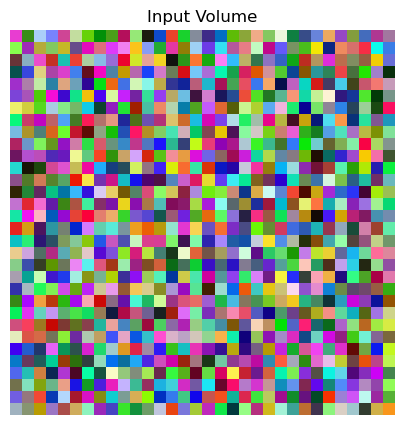

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


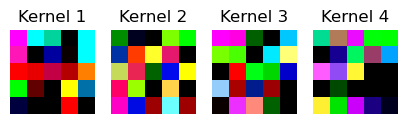

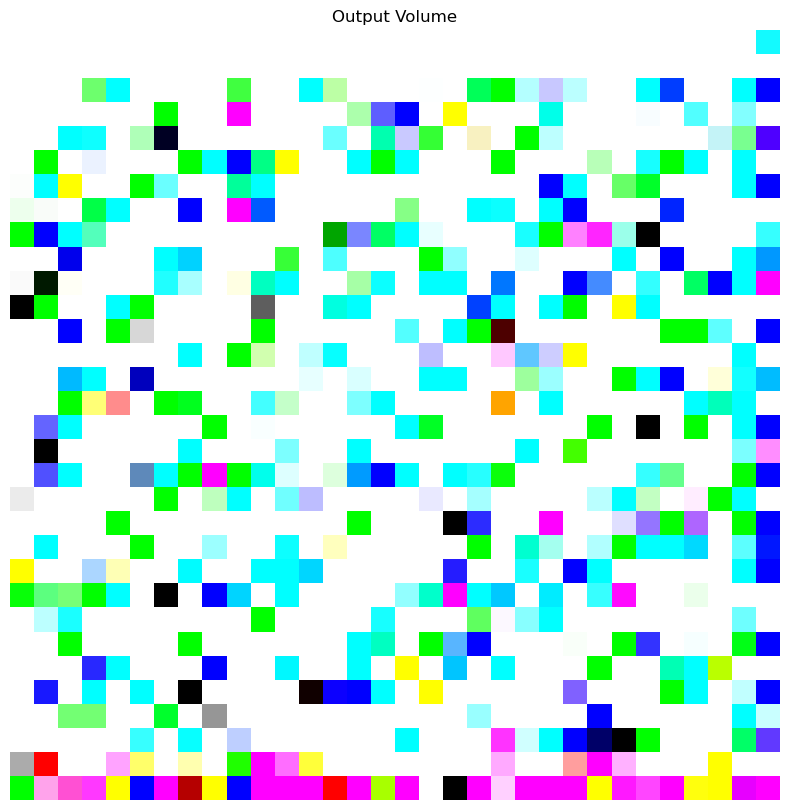

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


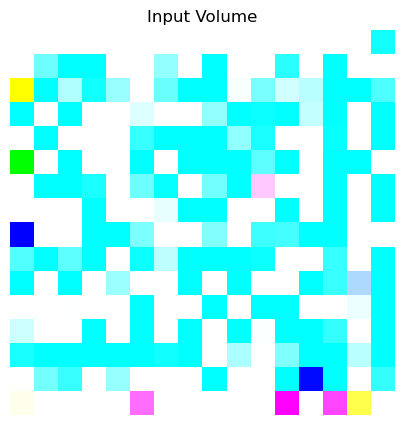

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


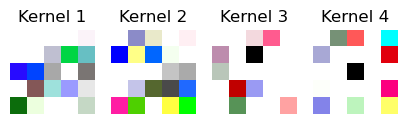

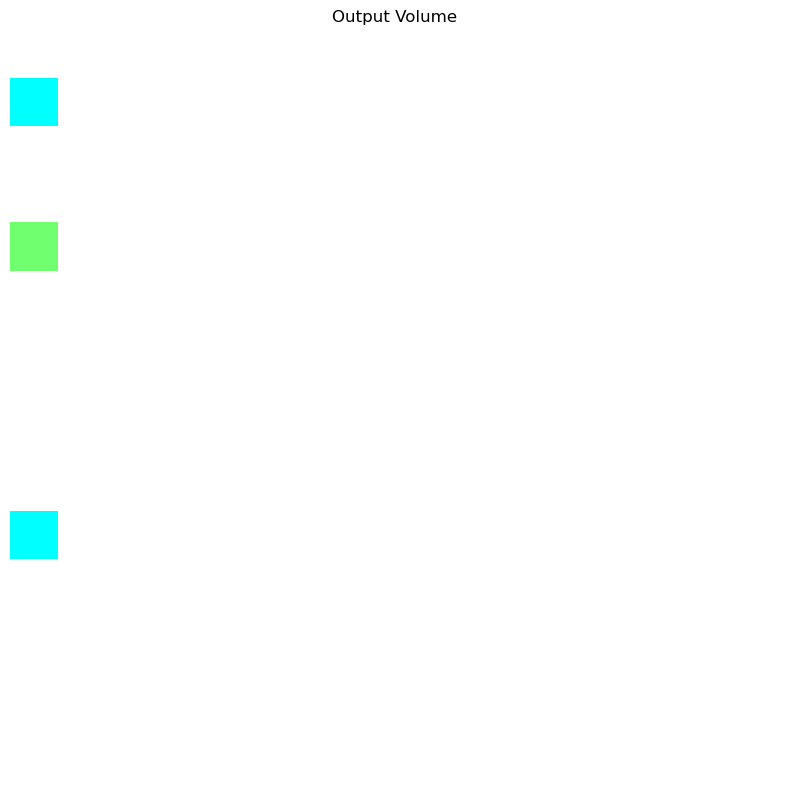

/tmp/ipykernel_11575/1828164958.py:14: RuntimeWarning: overflow encountered in exp
  return np.exp(output) / np.sum(np.exp(output))
/tmp/ipykernel_11575/1828164958.py:14: RuntimeWarning: invalid value encountered in divide
  return np.exp(output) / np.sum(np.exp(output))


Output vector for class 0: [ 0.  0.  0. nan  0.  0.  0.  0. nan nan]


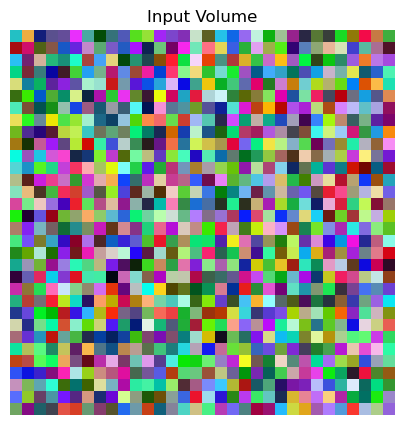

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


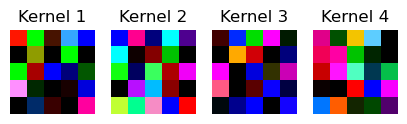

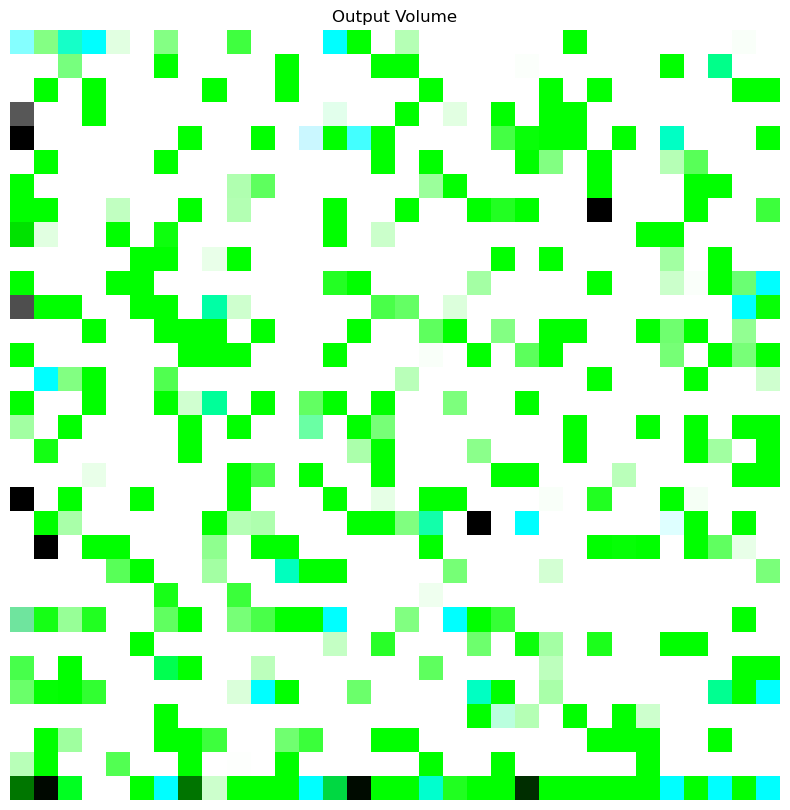

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


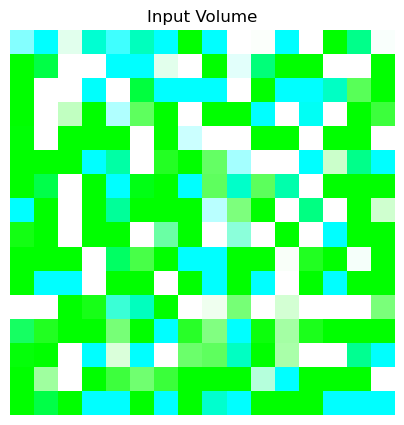

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


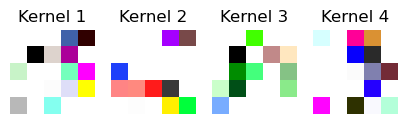

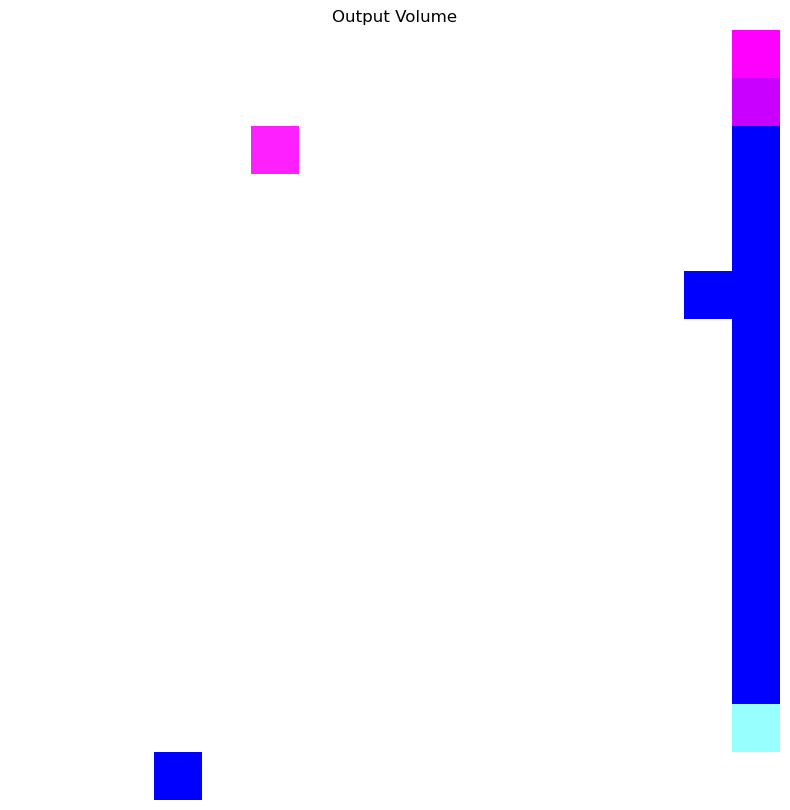

Output vector for class 1: [nan  0. nan nan  0.  0.  0. nan nan  0.]


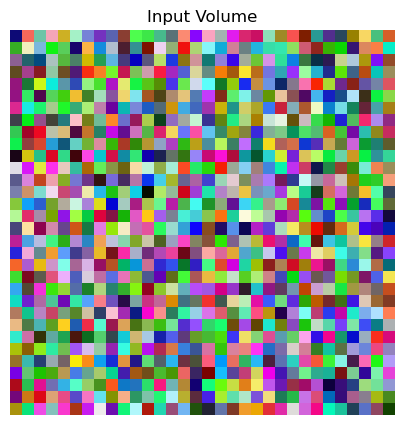

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


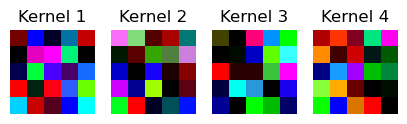

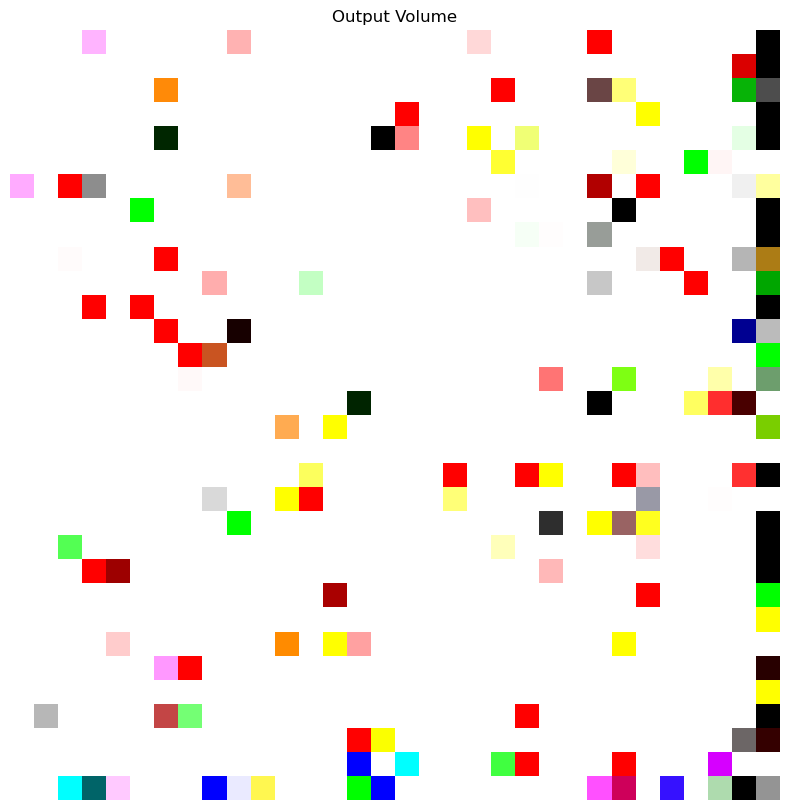

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


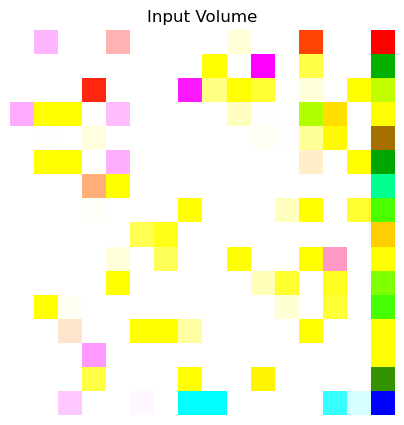

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


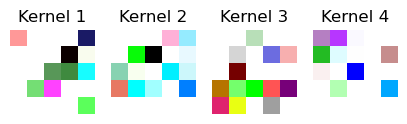

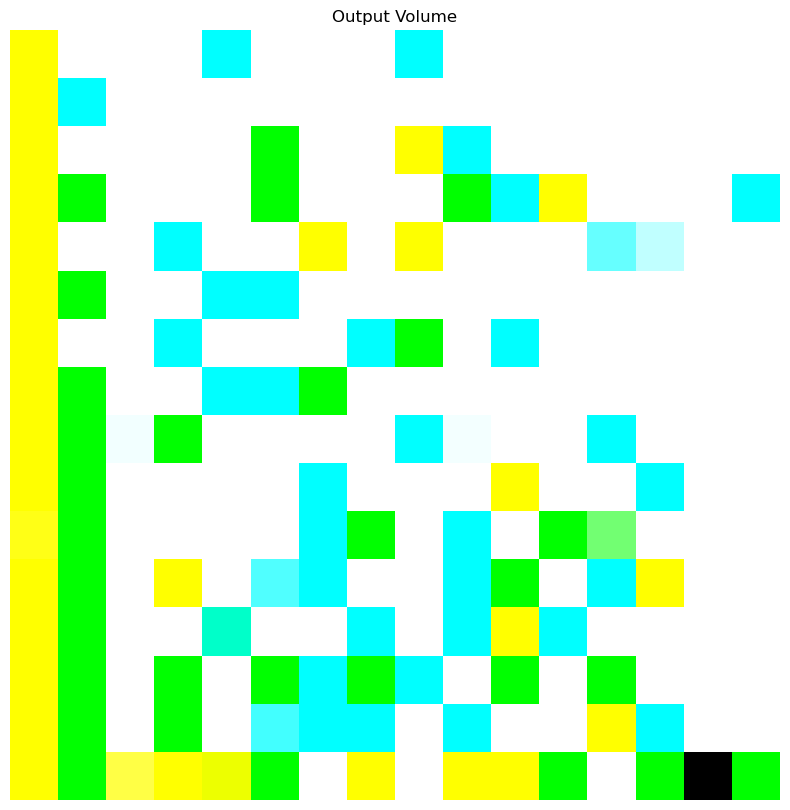

Output vector for class 2: [nan  0.  0.  0. nan nan  0.  0. nan  0.]


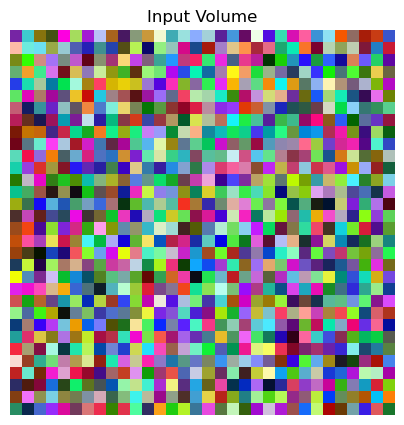

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


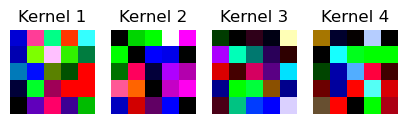

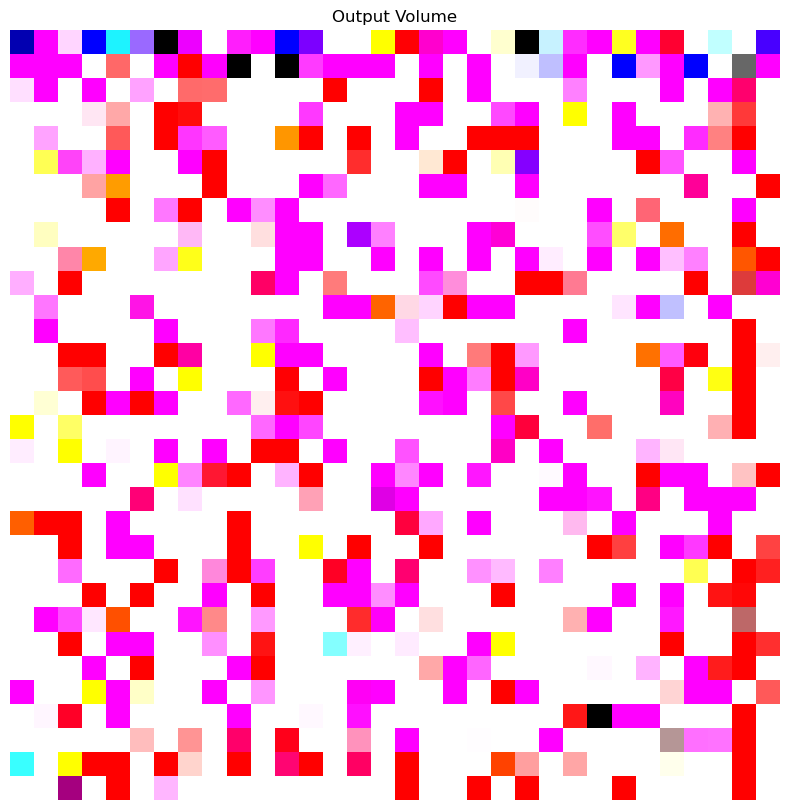

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


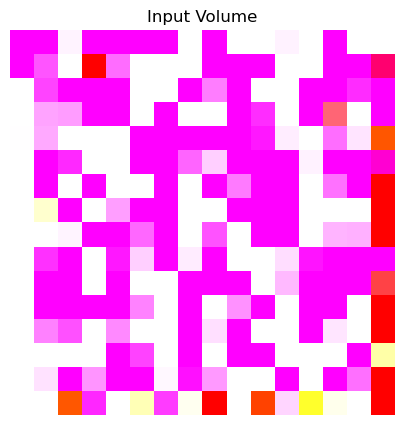

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


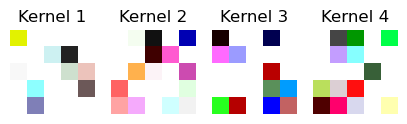

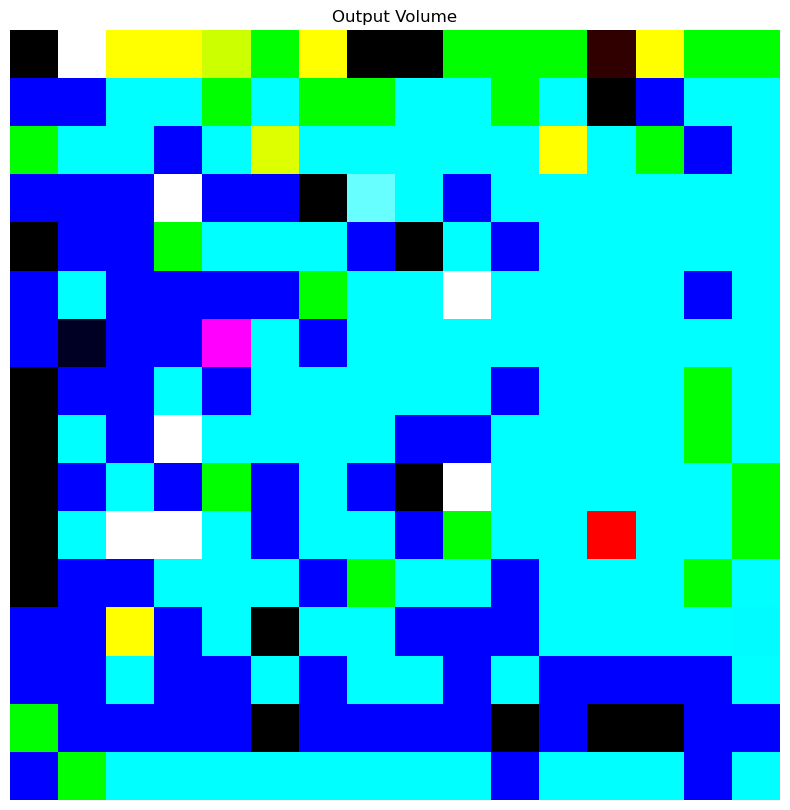

Output vector for class 3: [nan  0. nan  0. nan  0.  0. nan nan nan]


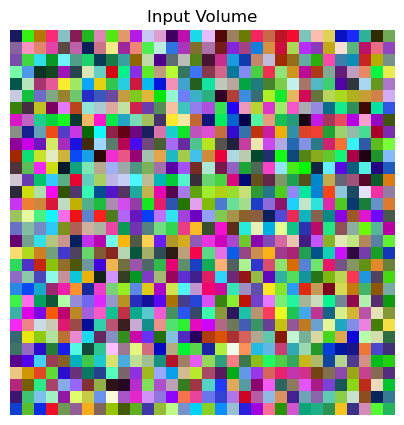

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


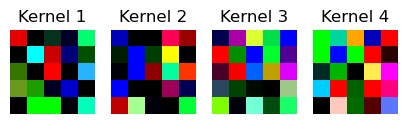

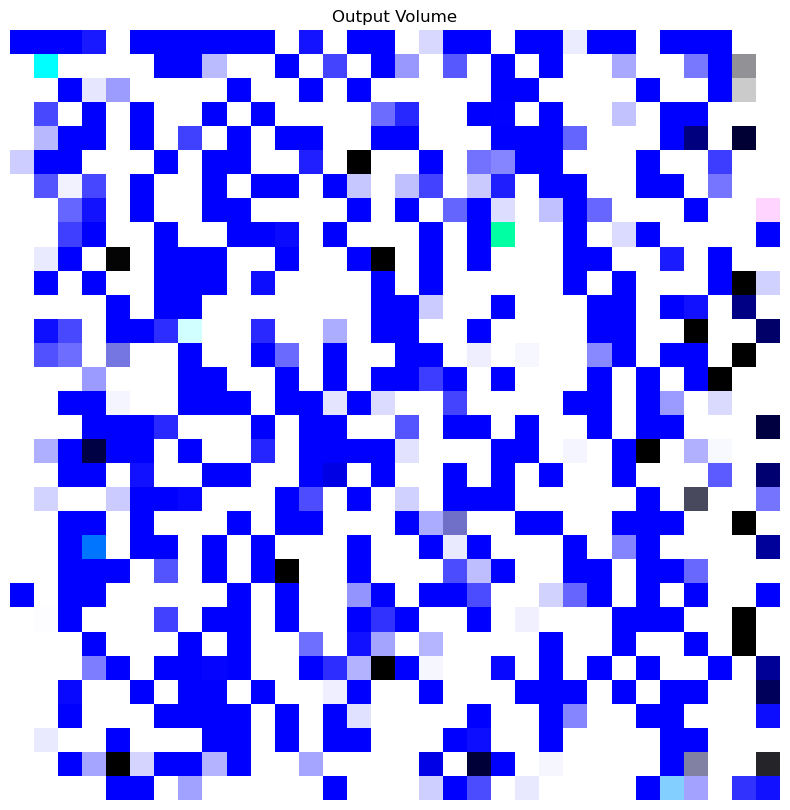

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


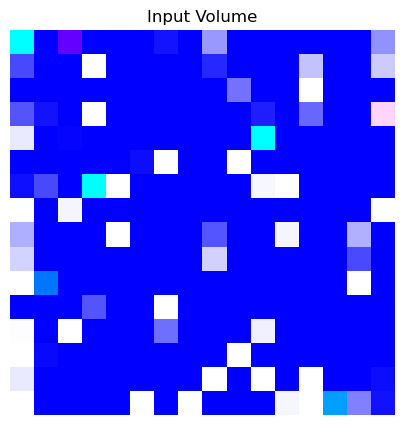

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


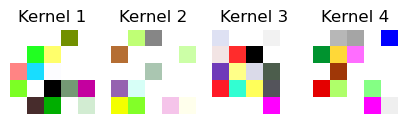

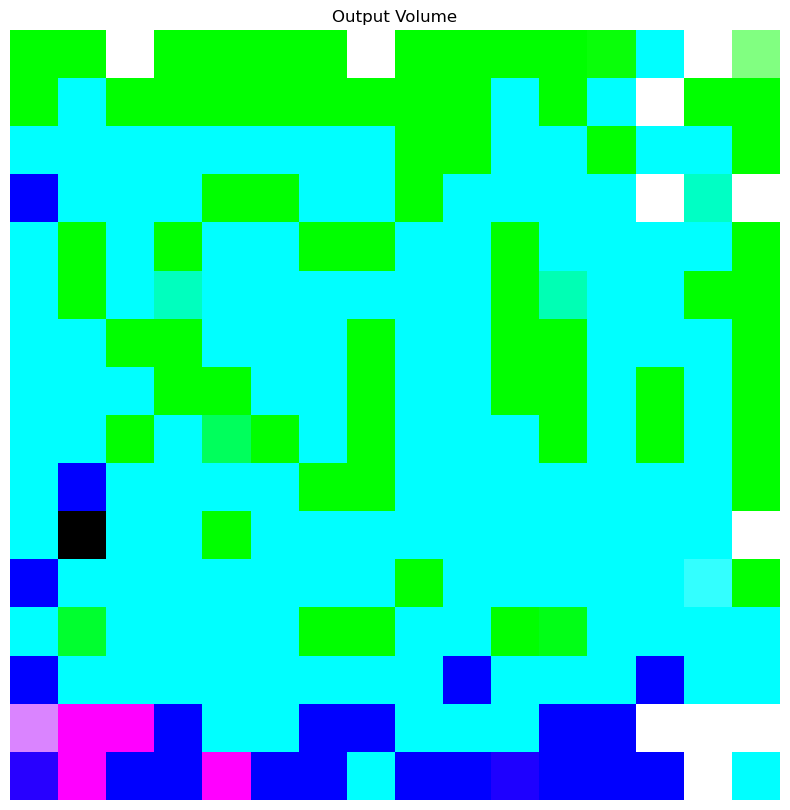

Output vector for class 4: [ 0.  0.  0.  0.  0.  0. nan  0. nan  0.]


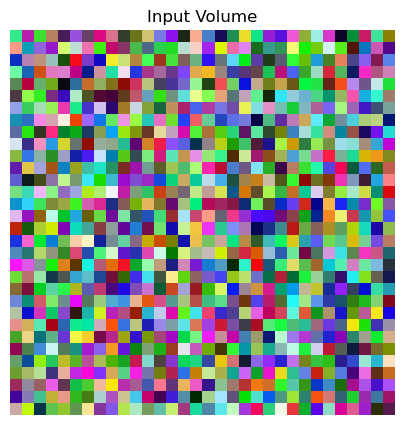

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


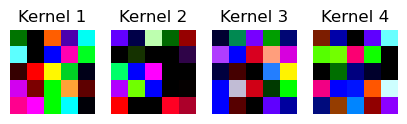

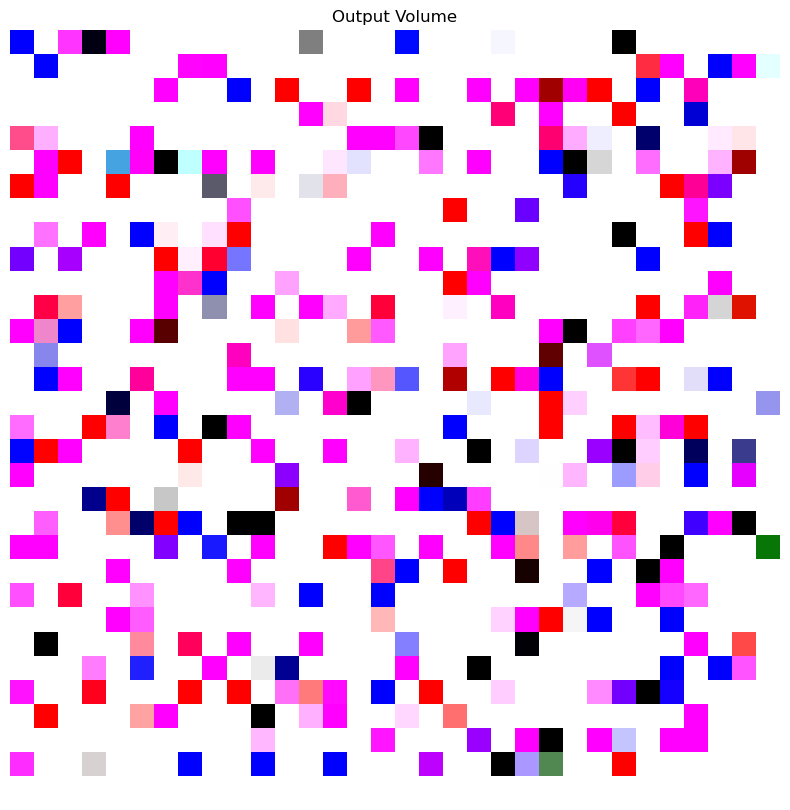

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


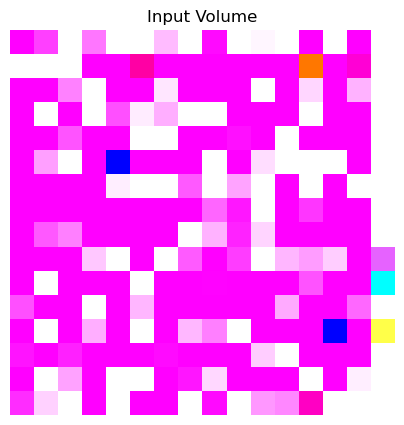

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


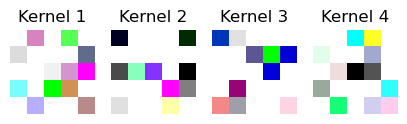

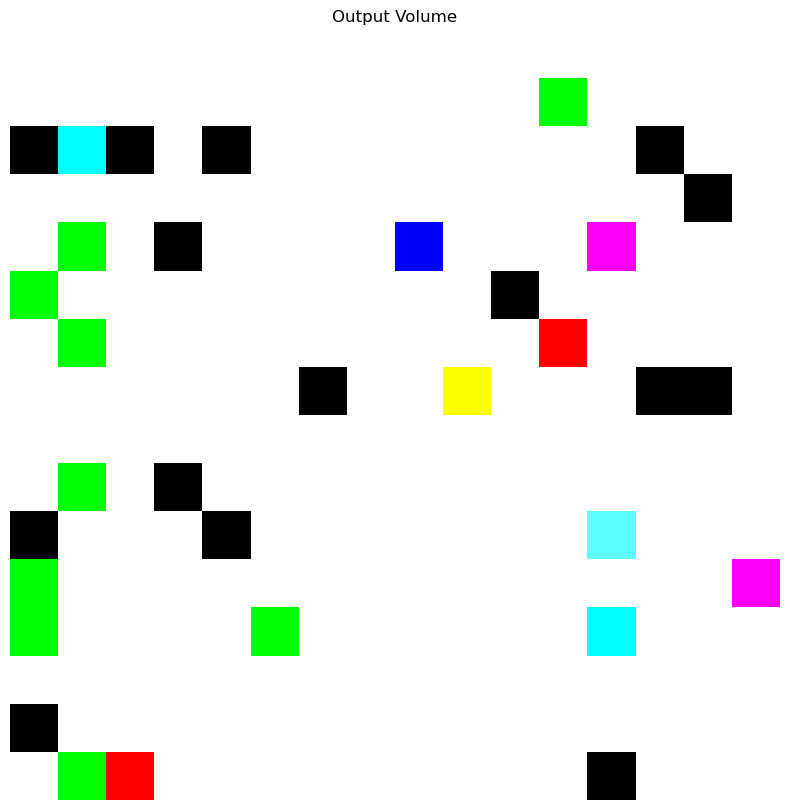

Output vector for class 5: [nan  0.  0.  0.  0.  0.  0. nan  0.  0.]


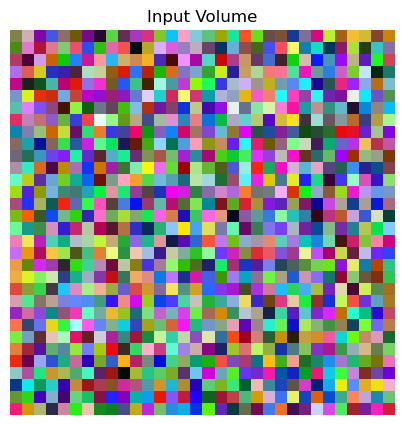

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


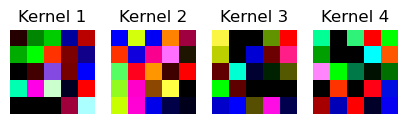

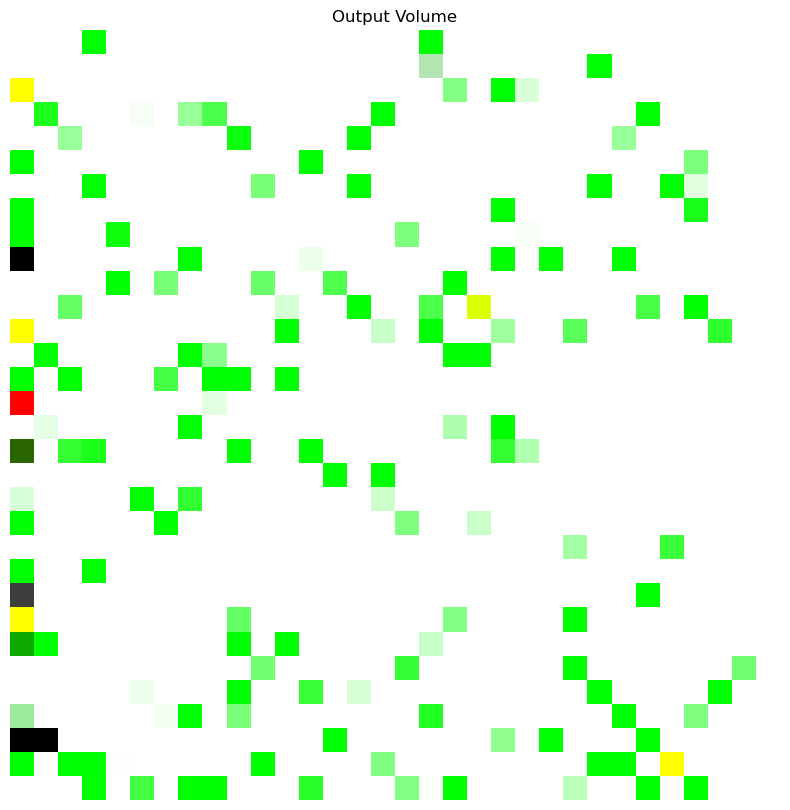

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


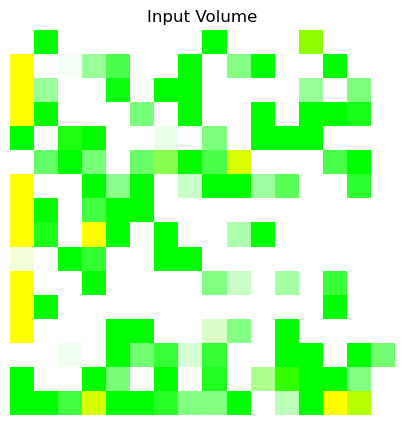

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


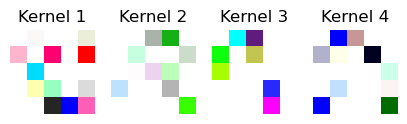

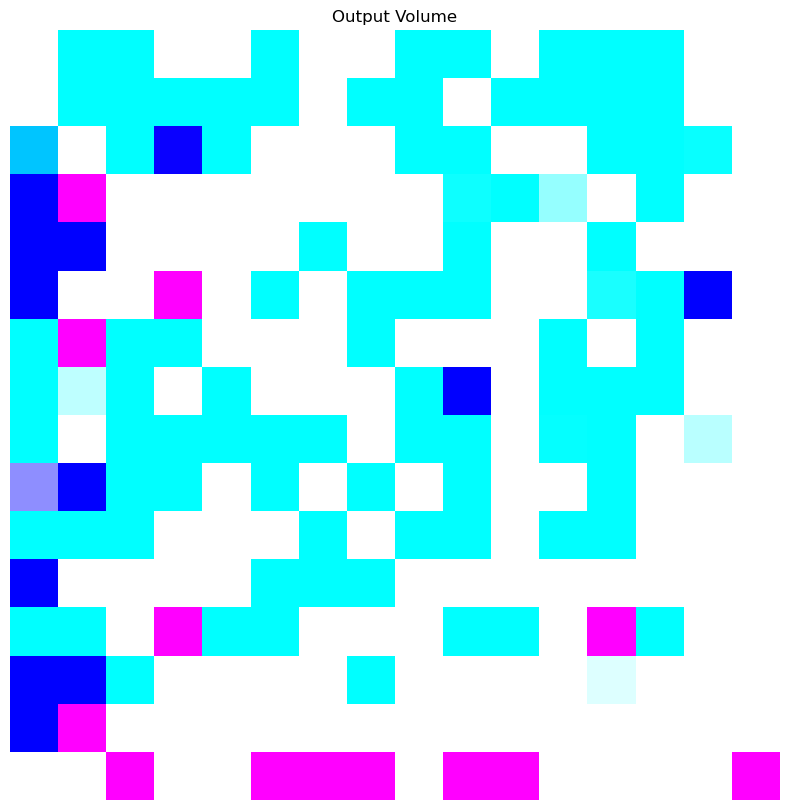

Output vector for class 6: [ 0. nan  0.  0.  0. nan  0. nan  0.  0.]


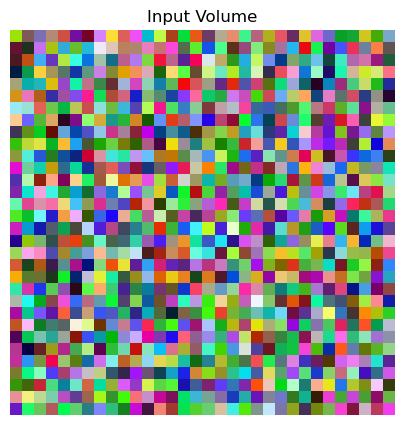

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


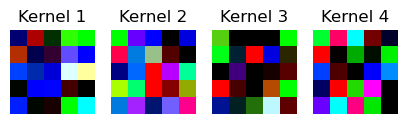

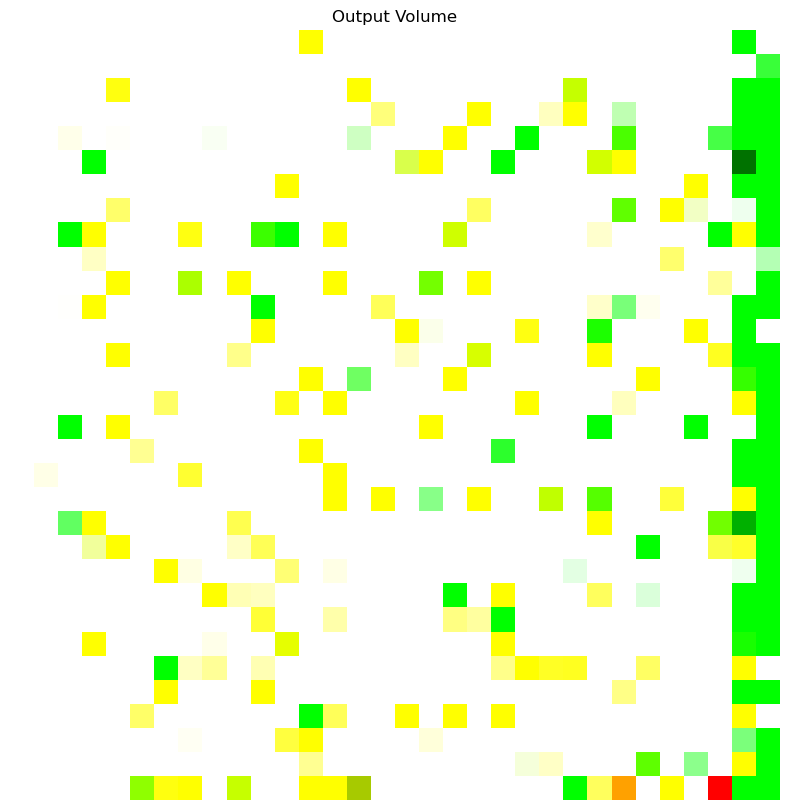

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


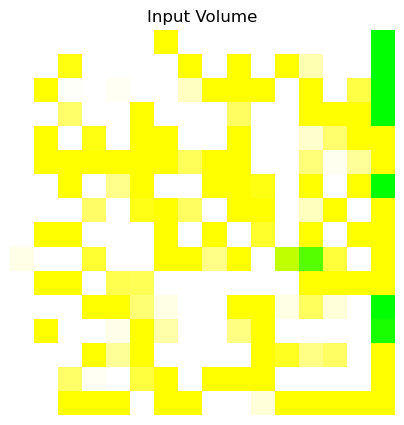

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


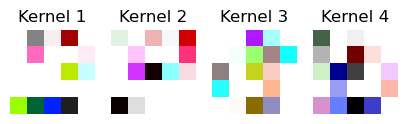

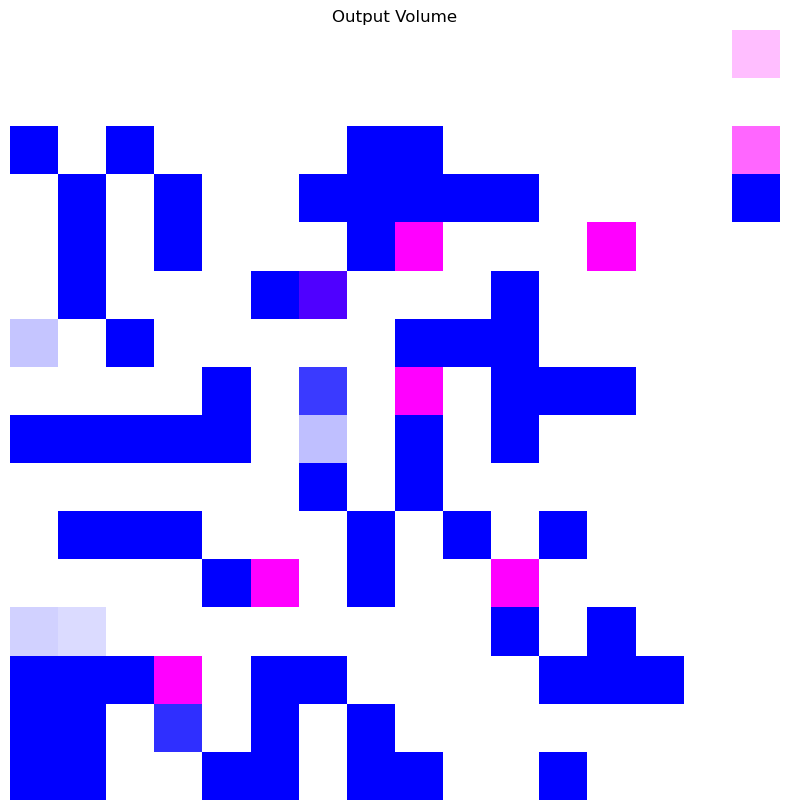

Output vector for class 7: [nan  0. nan nan nan  0.  0.  0.  0. nan]


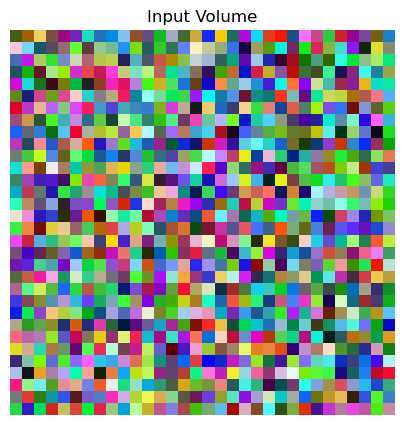

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


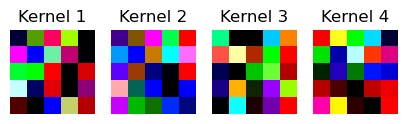

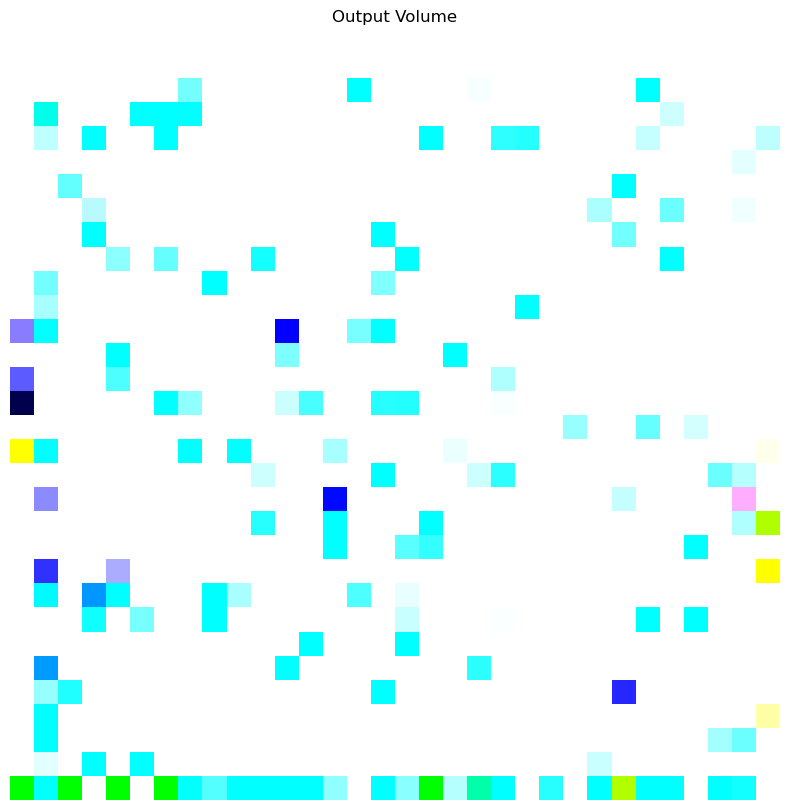

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


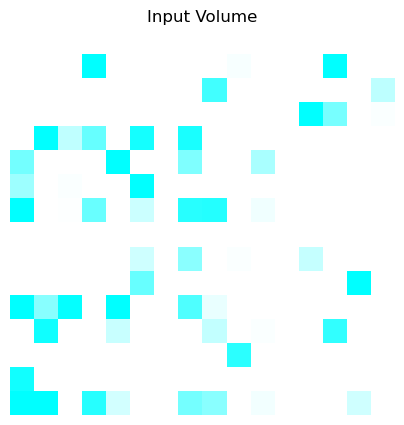

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


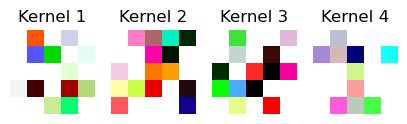

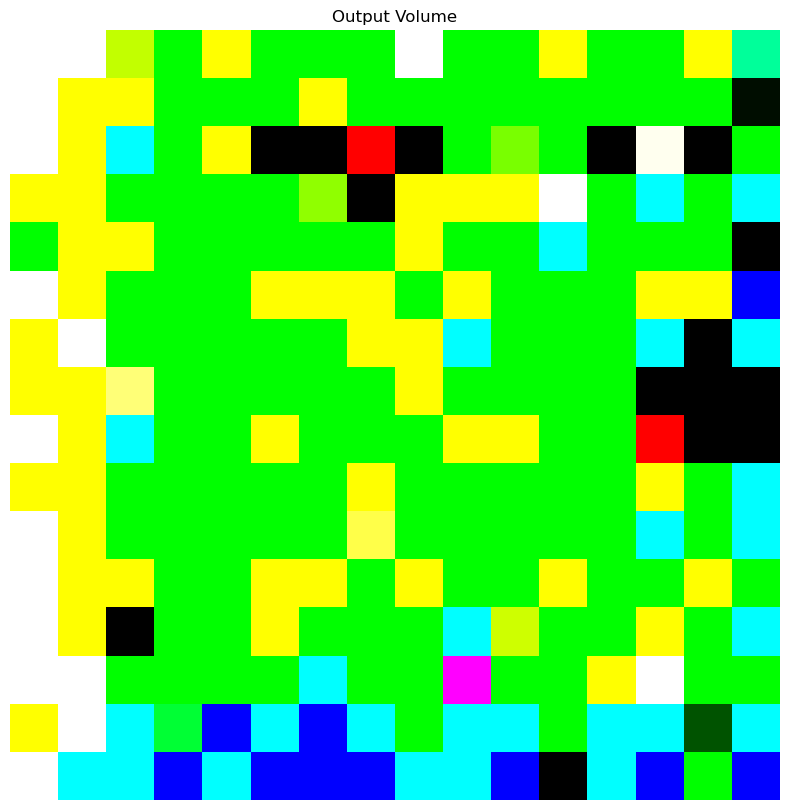

Output vector for class 8: [ 0. nan  0.  0.  0.  0. nan  0.  0. nan]


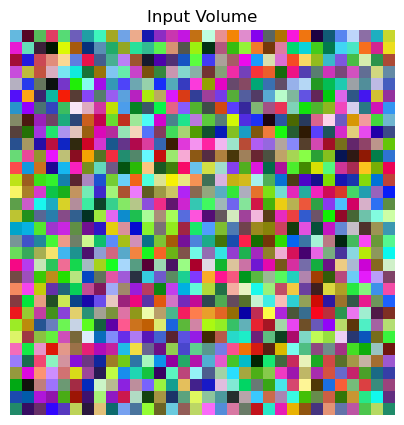

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


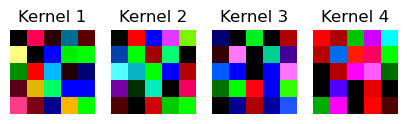

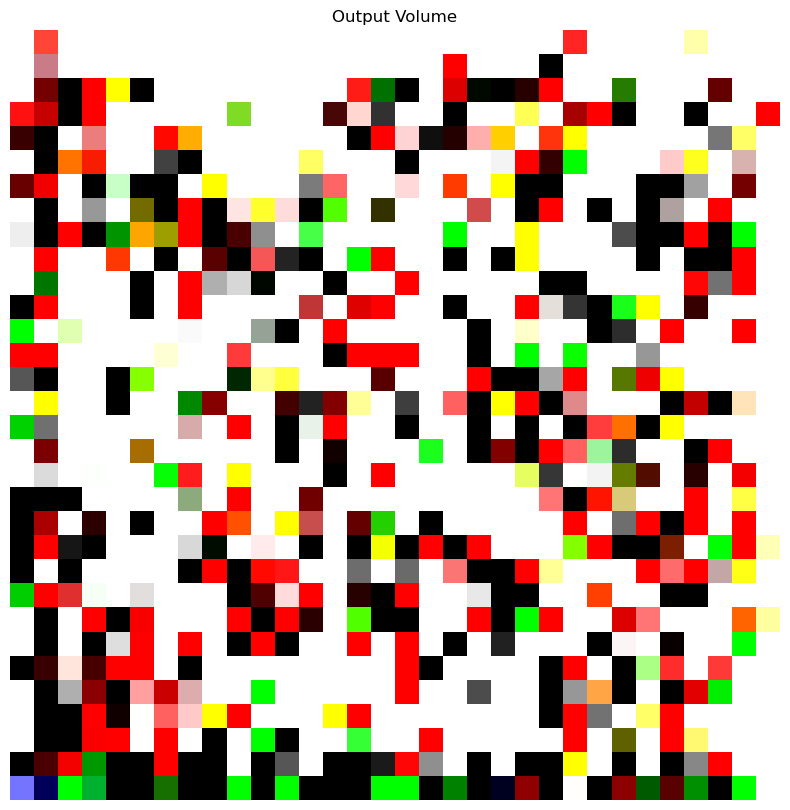

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


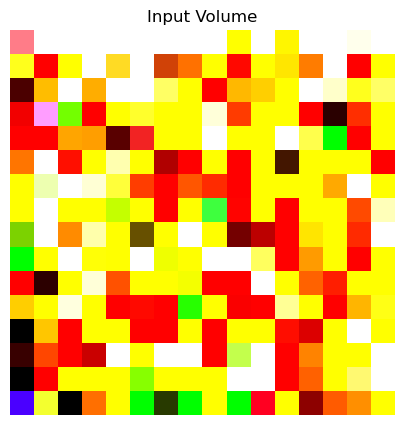

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


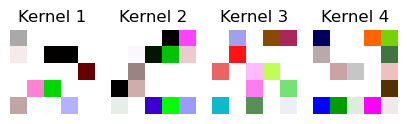

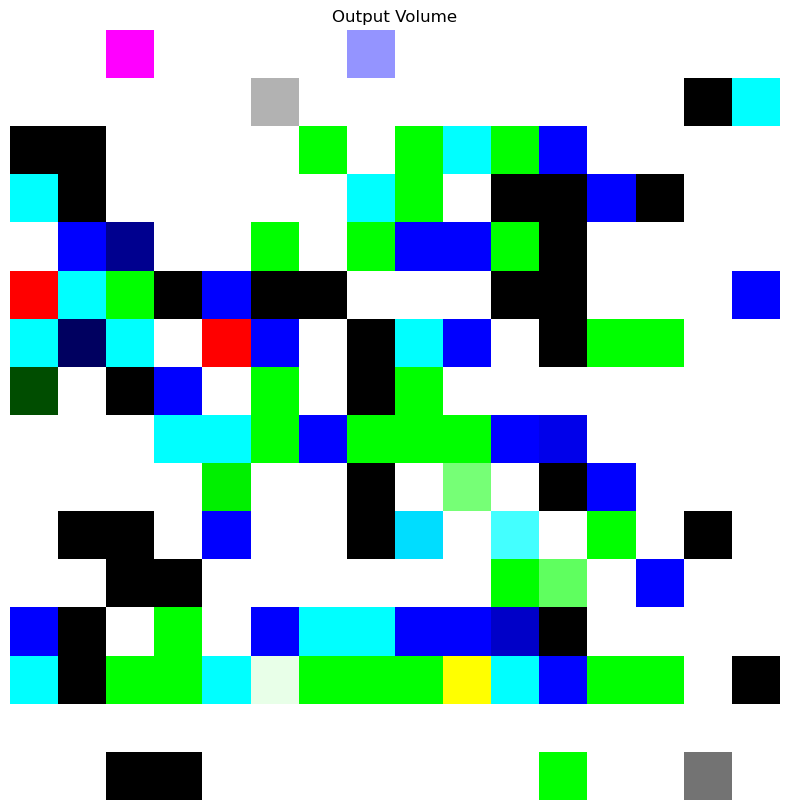

Output vector for class 9: [ 0.  0.  0. nan  0.  0.  0.  0.  0. nan]


In [39]:
# Testing with random images for each CIFAR-10 class
num_classes = 10
outputs = []

for i in range(num_classes):
    test_image = generate_random_image()
    output_vector = cnn_feed_forward(test_image)
    outputs.append(output_vector)
    print(f"Output vector for class {i}: {output_vector}")

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First Convolutional Layer: 3 input channels, 4 output channels, kernel size 5
        self.conv1 = nn.Conv2d(3, 4, kernel_size=5, padding=2)  # Output: 32x32x4
        self.pool = nn.MaxPool2d(2, 2)  # Max Pooling Layer: 2x2 pool
        # Second Convolutional Layer: 4 input channels, 4 output channels, kernel size 5
        self.conv2 = nn.Conv2d(4, 4, kernel_size=5, padding=2)  # Output: 16x16x4 after pooling
        # Flatten layer output before passing to fully connected
        self.fc1 = nn.Linear(4 * 8 * 8, 49)  # Hidden layer with 49 nodes
        self.fc2 = nn.Linear(49, 10)         # Output layer with 10 nodes (for CIFAR-10 classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))  # First conv layer with ReLU
        x = self.pool(x)               # First pooling layer
        x = torch.relu(self.conv2(x))  # Second conv layer with ReLU
        x = self.pool(x)               # Second pooling layer
        x = x.view(-1, 4 * 8 * 8)      # Flatten
        x = torch.relu(self.fc1(x))    # Fully connected layer with ReLU
        x = self.fc2(x)                # Output layer (no activation since we'll use CrossEntropyLoss)
        return x

In [17]:
# Define transforms for data normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Select a subset of 100 images per class (total 1000 images for training)
class_indices = {i: np.where(np.array(trainset.targets) == i)[0][:100] for i in range(10)}
subset_indices = np.concatenate([class_indices[i] for i in range(10)])
train_subset = Subset(trainset, subset_indices)

# DataLoader for training and testing
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [13]:
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs, labels
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy on test set: {100 * correct / total:.2f}%")

In [6]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function (CrossEntropyLoss) and move model to device
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()

# Training function
def train_model(model, optimizer, trainloader, num_epochs=15):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print loss statistics
            running_loss += loss.item()
            if i % 10 == 9:  # Print every 10 mini-batches
                print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss / 10:.3f}")
                running_loss = 0.0

        # Shuffle data after each epoch
        np.random.shuffle(train_subset.indices)

    print("Finished Training")

In [7]:
# Initialize a new model
model = SimpleCNN().to(device)
optimizer_sgd = optim.SGD(model.parameters(), lr=0.001)

print("Training with Vanilla SGD...")
train_model(model, optimizer_sgd, trainloader, num_epochs=15)

Training with Vanilla SGD...


[Epoch 1, Batch 10] loss: 2.305
[Epoch 2, Batch 10] loss: 2.305
[Epoch 3, Batch 10] loss: 2.308
[Epoch 4, Batch 10] loss: 2.306
[Epoch 5, Batch 10] loss: 2.306
[Epoch 6, Batch 10] loss: 2.307
[Epoch 7, Batch 10] loss: 2.310
[Epoch 8, Batch 10] loss: 2.309
[Epoch 9, Batch 10] loss: 2.307
[Epoch 10, Batch 10] loss: 2.306
[Epoch 11, Batch 10] loss: 2.306
[Epoch 12, Batch 10] loss: 2.307
[Epoch 13, Batch 10] loss: 2.305
[Epoch 14, Batch 10] loss: 2.306
[Epoch 15, Batch 10] loss: 2.304
Finished Training


In [18]:
net = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 9 %


In [20]:
print(total)

10000
